# Análisis de Univariado

In [121]:
import pandas as pd
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.stats import zscore
from IPython.display import display
from scipy.stats import skew, kurtosis
import matplotlib.ticker as mtick
from matplotlib.patches import Patch

In [122]:
df = pd.read_parquet("df_light_cleaned.parquet", engine="pyarrow")

In [123]:
df.dtypes

nomeProduto                                  string[python]
numeroProcesso                               string[python]
empresaNome                                  string[python]
principioAtivo                               string[python]
tarja                                              category
medicamentoReferencia                        string[python]
classesTerapeuticas                          string[python]
categoriaRegulatoria                               category
dataProduto                                  datetime64[ns]
dataVencimentoRegistro                       datetime64[ns]
dataPublicacao                               datetime64[ns]
apresentacoes.codigo                         string[python]
apresentacao                                 string[python]
apresentacoes.dataPublicacao                 datetime64[ns]
registro                                     string[python]
principiosAtivos                             string[python]
embalagemSecundariaTodas                

In [124]:
df.tarja.unique()

['Vermelha sob restrição', 'Vermelha', NaN, 'Sem Tarja', 'Preta']
Categories (4, object): ['Preta', 'Sem Tarja', 'Vermelha', 'Vermelha sob restrição']

In [125]:
 #traducir columna 'tarja' al español
df['tarja'] = df['tarja'].cat.add_categories(["No informado"])
traducciones = {
    'Vermelha sob restrição': 'Franja roja con restricción',
    'Vermelha': 'Franja roja',
    'Sem Tarja': 'Sin franja',
    'Preta': 'Franja negra'
}

df['tarja_es'] = df['tarja'].map(traducciones).fillna('No informado')


In [126]:
df['tarja_es'].value_counts(dropna=False)


tarja_es
Franja roja                    96125
No informado                   56049
Franja roja con restricción    31548
Sin franja                     19507
Franja negra                    3764
Name: count, dtype: int64

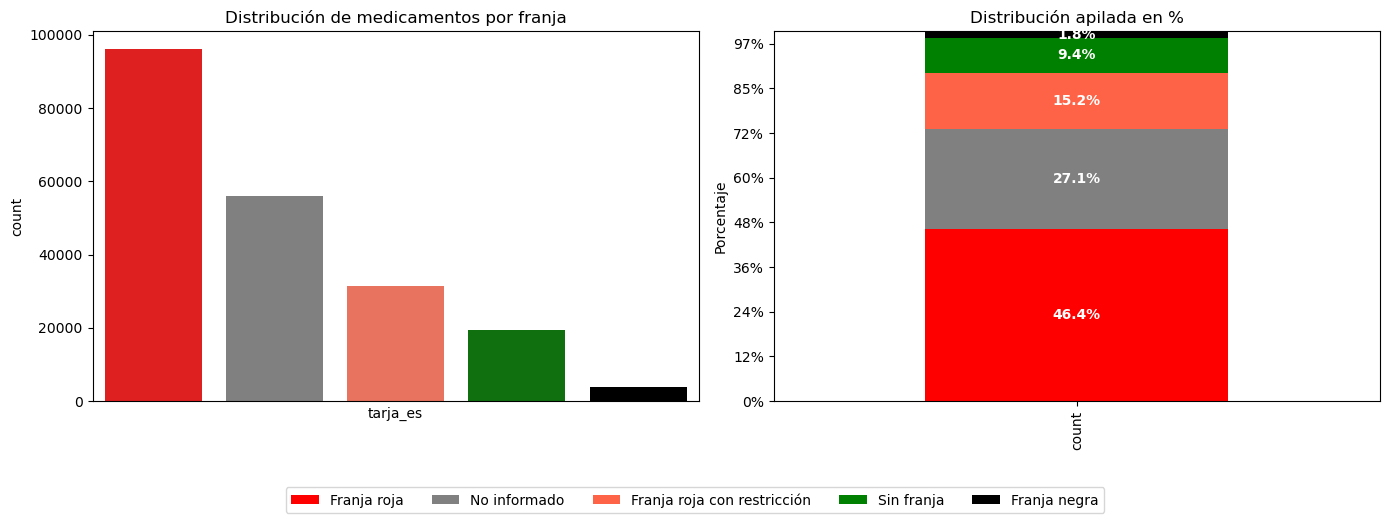

In [127]:

import matplotlib.ticker as mtick
from matplotlib.patches import Patch

# --- Preparar datos ---
orden = df['tarja_es'].value_counts().index
counts = df['tarja_es'].value_counts()
total = counts.sum()
porcentajes = counts / total * 100
data = counts.to_frame().T

# --- Paleta de colores fija por categoría ---
colores = {
    'Franja roja con restricción': 'tomato',
    'Franja roja': 'red',
    'Franja negra': 'black',
    'Sin franja': 'green',
    'No informado': 'gray'
}

# --- Figura con 2 columnas ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- 1) Countplot en axes[0] ---
sns.countplot(
    data=df,
    x='tarja_es',
    order=orden,
    hue='tarja_es',
    ax=axes[0],
    legend=False,
    palette=colores
)
axes[0].set_title("Distribución de medicamentos por franja")
axes[0].set_xticks([])
axes[0].set_xticklabels([])

# --- 2) Barra apilada en axes[1] ---
ax = data.plot(
    kind='bar',
    stacked=True,
    color=[colores[c] for c in data.columns],
    legend=False,
    ax=axes[1]                  # 👈 usar el segundo subplot
)

# Eje Y en %
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=total))
axes[1].set_title("Distribución apilada en %")
axes[1].set_xlabel("")
axes[1].set_ylabel("Porcentaje")
axes[1].set_ylim(0, total)     # opcional; con el formatter se verá 0–100%

# % dentro de cada segmento
acum = 0
for cat, val in counts.items():
    y = acum + val/2
    axes[1].text(
        0, y, f"{porcentajes[cat]:.1f}%",
        ha="center", va="center", color="white",
        fontsize=10, fontweight="bold"
    )
    acum += val

# Leyenda única
handles = [Patch(facecolor=colores[c], label=c) for c in orden]
fig.legend(handles=handles, loc="lower center",
           ncol=len(orden), bbox_to_anchor=(0.5, -0.05))

# Ajuste para que quepa la leyenda
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()



| **Franja**                                                    | **Significado**                                                              | **Requisitos de venta**                                            | **Ejemplos comunes**                      |
| ------------------------------------------------------------- | ---------------------------------------------------------------------------- | ------------------------------------------------------------------ | ----------------------------------------- |
|  **Sin franja** (*Sem tarja*)                               | Medicamentos de **venta libre**.                                             | No requieren receta médica.                                        | Analgésicos simples, antiácidos.          |
| **Franja roja** (*Vermelha*)                               | Medicamentos que requieren **receta médica**.                                | Receta simple, no queda retenida en la farmacia.                   | Anti-inflamatorios, antibióticos tópicos. |
|  **Franja roja con restricción** (*Vermelha sob restrição*) | Medicamentos bajo **receta retenida**.                                       | La farmacia debe **retener la receta** como control.               | Antibióticos orales, ansiolíticos.        |
| ⚫ **Franja negra** (*Preta*)                                  | Medicamentos de **control especial** (alto riesgo de dependencia o efectos). | Requieren **receta especial en dos copias** autorizada por ANVISA. | Psicotrópicos, anfetaminas, opioides.     |


In [128]:
df.categoriaRegulatoria.unique().tolist()


['Genérico',
 'Similar',
 'Biológico',
 'Específico',
 'Novo',
 'Produto de Terapia Avançada',
 'Dinamizado',
 'Fitoterápico',
 'Radiofármaco',
 nan]

                              conteo  porcentaje
categoriaRegulatoria_es                         
Genérico                       82314       39.77
Similar                        54120       26.15
Específico                     24325       11.75
Nuevo                          23165       11.19
Biológico                      17969        8.68
Fitoterápico                    3260        1.57
Dinamizado                      1027        0.50
No informado                     522        0.25
Producto de Terapia Avanzada     173        0.08
Radiofármaco                     118        0.06


/tmp/ipykernel_99454/2600571884.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([""])


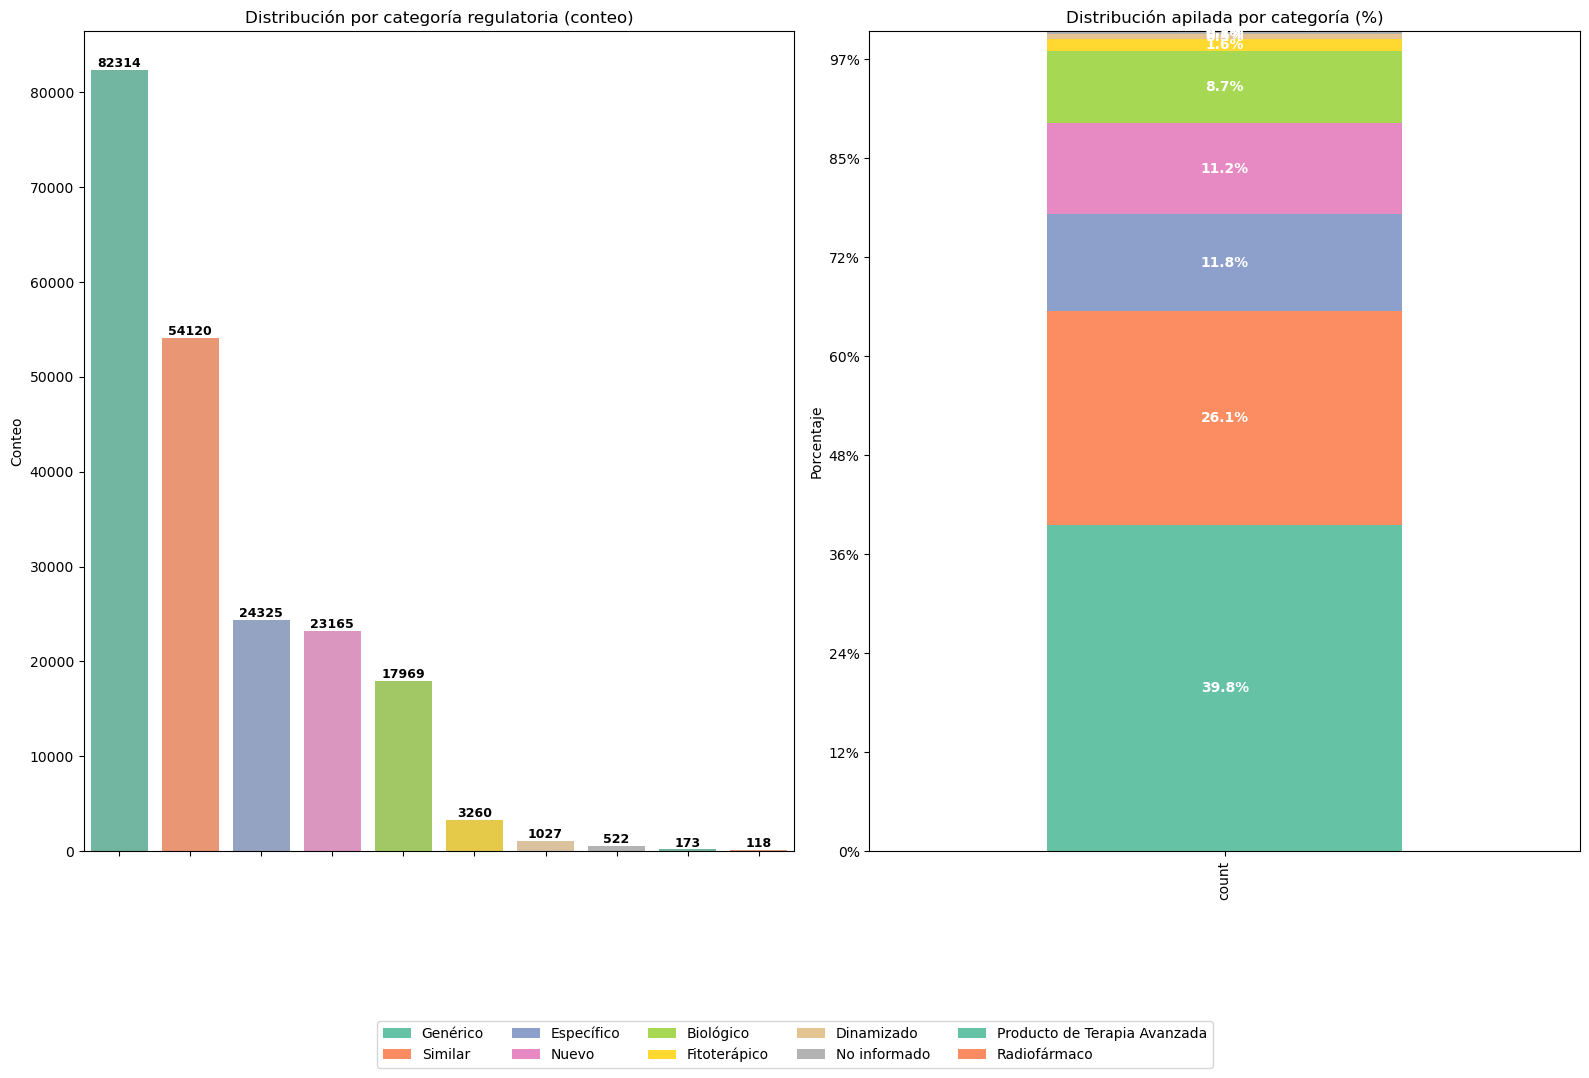

In [129]:

# --- Traducción categorías ---
traducciones = {
    "Genérico": "Genérico",
    "Similar": "Similar",
    "Biológico": "Biológico",
    "Específico": "Específico",
    "Novo": "Nuevo",
    "Produto de Terapia Avançada": "Producto de Terapia Avanzada",
    "Dinamizado": "Dinamizado",
    "Fitoterápico": "Fitoterápico",
    "Radiofármaco": "Radiofármaco",
    np.nan: "No informado"
}

df["categoriaRegulatoria_es"] = df["categoriaRegulatoria"].map(traducciones)
desc = df["categoriaRegulatoria_es"].value_counts(dropna=False).to_frame(name="conteo")
desc["porcentaje"] = round(100 * desc["conteo"] / len(df), 2)

print(desc)
# 2) Preparar orden (mayor a menor) y conteos
orden = df['categoriaRegulatoria_es'].value_counts().index
counts = df['categoriaRegulatoria_es'].value_counts()
total = counts.sum()
porcentajes = counts / total * 100
data = counts.to_frame().T  # una fila para stacked

# 3) Paleta de colores consistente por categoría

colores_base = sns.color_palette('Set2', n_colors=len(orden))
colores = {cat: colores_base[i] for i, cat in enumerate(orden)}

# 4) Figura con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# --- (A) Conteo por categoría ---
sns.countplot(
    data=df,
    x='categoriaRegulatoria_es',
    order=orden,
    hue='categoriaRegulatoria_es',
    palette=colores,
    legend=False,
    ax=axes[0]
)
for p in axes[0].patches:
    height = p.get_height()
    if height > 0:  
        axes[0].text(
            p.get_x() + p.get_width() / 2,   
            height + 0.5,                    
            int(height),                     
            ha="center", va="bottom", fontsize=9, fontweight="bold"
        )
axes[0].set_title("Distribución por categoría regulatoria (conteo)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Conteo")
axes[0].set_xticklabels([""])
# --- (B) Barra apilada con % ---
ax = data[orden].plot(                  
    kind='bar',
    stacked=True,
    color=[colores[c] for c in orden],
    legend=False,
    ax=axes[1]
)

# Eje Y en % (0–100)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=total))
axes[1].set_ylim(0, total)
axes[1].set_title("Distribución apilada por categoría (%)")
axes[1].set_xlabel("")
axes[1].set_ylabel("Porcentaje")

# Añadir % dentro de cada segmento
acum = 0
for cat, val in counts[orden].items():
    y = acum + val/2
    axes[1].text(
        0, y, f"{(val/total*100):.1f}%",
        ha="center", va="center", color="white",
        fontsize=10, fontweight="bold"
    )
    acum += val

# 5) Leyenda única compartida
handles = [Patch(facecolor=colores[c], label=c) for c in orden]
fig.legend(handles=handles, loc="lower center",
           ncol=min(len(orden), 5), bbox_to_anchor=(0.5, -0.08))

plt.tight_layout(rect=[0, 0.08, 1, 1])  
plt.show()

| Categoría                        | Significado                                                                                                                             |
| -------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| **Genérico**                     | Medicamento con el mismo principio activo, forma, dosis y eficacia que el de referencia, pero sin marca.                                |
| **Similar**                      | Medicamento con el mismo principio activo que el de referencia, pero puede diferir en características como forma, excipientes o envase. |
| **Biológico**                    | Producto elaborado a partir de organismos vivos (ej. anticuerpos, vacunas, proteínas recombinantes).                                    |
| **Específico**                   | Categoría para medicamentos que no encajan en genérico, similar o biológico, con regulación propia (ej. vitaminas, probióticos).        |
| **Nuevo**                        | Medicamento innovador.                   |
| **Producto de Terapia Avanzada** | Medicamentos de biotecnología avanzada como terapia génica, celular o de ingeniería tisular.                                            |
| **Dinamizado**                   | Medicamentos homeopáticos, elaborados mediante diluciones sucesivas.                                                                    |
| **Fitoterápico**                 | Medicamentos elaborados a partir de plantas medicinales con evidencia de eficacia y seguridad.                                          |
| **Radiofármaco**                 | Medicamentos que contienen radionúclidos, usados en diagnóstico o terapia nuclear.                                                      |
| **No informado**                 | Casos donde no se reportó la categoría en el registro.                                                                                  |


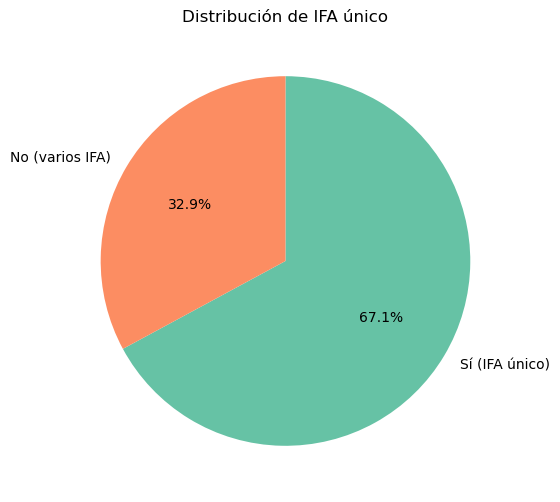

In [130]:
col = "ifaUnico"

# Conteo incluyendo nulos
counts = df[col].value_counts(dropna=False)
labels = counts.index.map({True: "Sí (IFA único)", False: "No (varios IFA)", np.nan: "No informado"})

# Colores de Seaborn
colors = sns.color_palette("Set2", n_colors=len(counts))

# Gráfico de torta
plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, counterclock=False)
plt.title("Distribución de IFA único")
plt.show()



##### Distribución de IFA único

El Ingrediente Farmacéutico Activo (IFA), también conocido como principio activo, es la sustancia responsable del efecto terapéutico de un medicamento. Cuando un producto contiene un solo principio activo se clasifica como IFA único, mientras que aquellos que combinan dos o más principios activos se consideran múltiples IFA.

En la gráfica observamos que el 67,1% de los medicamentos registrados corresponden a productos con IFA único, mientras que el 32,9% son combinaciones con varios IFA. Esto indica que la mayoría de los medicamentos en la base de datos son formulaciones simples, aunque una tercera parte del mercado corresponde a combinaciones, que suelen responder a estrategias terapéuticas específicas o a diferenciación comercial.

In [131]:
# Diccionario de traducción
map_restricao = {
    'Venda sob prescrição médica com retenção de receita': 'Venta bajo prescripción médica con retención de receta',
    'Venda sob Prescrição Médica': 'Venta bajo prescripción médica',
    'Venda sem Prescrição Médica': 'Venta sin prescripción médica',
    'Venda Sob Prescrição Médica Sujeita a Notificação de Receita "A"': 'Venta bajo prescripción médica sujeta a notificación de receta tipo A',
    'Venda Sob Receita de Controle Especial': 'Venta bajo receta de control especial',
    'Venda Sob Prescrição Médica Sujeita a Notificação de Receita "B"': 'Venta bajo prescripción médica sujeta a notificación de receta tipo B',
    'Venda Sob Prescrição Médica Sujeita a Notificação de Receita "B2"': 'Venta bajo prescripción médica sujeta a notificación de receta tipo B2',
    'Dispensação Sujeita a Receituário do Programa DST/AIDS': 'Dispensación sujeta a recetario del programa ITS/VIH-SIDA'
}

# Convertir a string para evitar problemas con Categorical
df['restricaoPrescricao'] = df['restricaoPrescricao'].astype("string")

# Aplicar traducción y reemplazar nulos
df['restricaoPrescricao_es'] = (
    df['restricaoPrescricao']
    .map(map_restricao)
    .fillna("No informado")
)


/tmp/ipykernel_99454/1243123374.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([""])


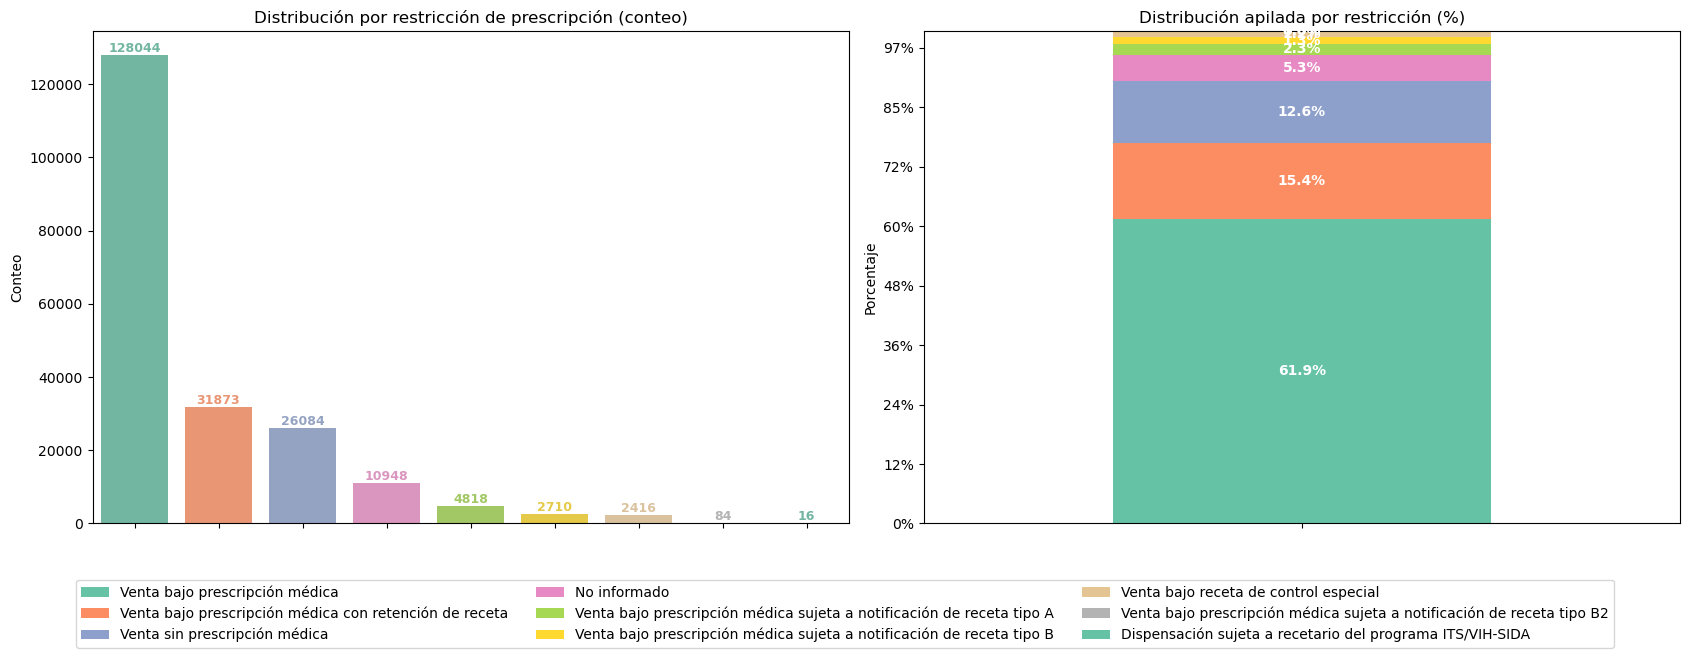

In [132]:
# 1) Preparar datos
orden = df['restricaoPrescricao_es'].value_counts().index
counts = df['restricaoPrescricao_es'].value_counts()
total = counts.sum()
data = counts.to_frame().T  # para la barra apilada

# 2) Paleta consistente por categoría (tomada del orden)
colores_base = sns.color_palette('Set2', n_colors=len(orden))
colores = {cat: colores_base[i] for i, cat in enumerate(orden)}

# 3) Figura 1x2
fig, axes = plt.subplots(1, 2, figsize=(17, 6))

# --- A) Conteo por categoría ---
sns.countplot(
    data=df,
    x='restricaoPrescricao_es',
    order=orden,
    hue='restricaoPrescricao_es',
    palette=colores,
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Distribución por restricción de prescripción (conteo)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Conteo")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xticklabels([""])


# Etiquetas de valor encima de cada barra
for p in axes[0].patches:
    h = p.get_height()
    if h > 0:
        axes[0].text(
            p.get_x() + p.get_width()/2,
            h + 0.5,
            f"{int(h)}",
            ha="center", va="bottom", fontsize=9, fontweight="bold", color=p.get_facecolor() 
        )

# --- B) Barra apilada en % ---
ax = data[orden].plot(
    kind='bar',
    stacked=True,
    color=[colores[c] for c in orden],
    legend=False,
    ax=axes[1]
)

# Eje Y en %
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=total))
axes[1].set_ylim(0, total)  # con el formateador se verá 0–100%
axes[1].set_title("Distribución apilada por restricción (%)")
axes[1].set_xlabel("")
axes[1].set_ylabel("Porcentaje")
axes[1].set_xticklabels([""])  # sólo una barra

# % dentro de cada segmento
acum = 0
for cat in orden:
    val = counts[cat]
    y = acum + val/2
    pct = val / total * 100
    axes[1].text(
        0, y, f"{pct:.1f}%",
        ha="center", va="center", color="white",
        fontsize=10, fontweight="bold"
    )
    acum += val

# Leyenda única compartida (misma paleta en ambos)
handles = [Patch(facecolor=colores[c], label=c) for c in orden]
fig.legend(handles=handles, loc="lower center",
           ncol=min(len(orden), 3), bbox_to_anchor=(0.5, -0.1))

plt.tight_layout(rect=[0, 0.08, 1, 1])  
plt.show()

| **Categoría**                                                    | **Significado**                                                                               | **Requisitos de venta**                                                            |
| -------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **Venta bajo prescripción médica con retención de receta**                 | Medicamentos que requieren receta y la farmacia **debe retenerla**.                           | Receta médica **retenida** en la farmacia como control.                            |
| **Venta bajo prescripción médica**                                         | Medicamentos que requieren receta médica, pero **no se retiene**.                             | Presentación de receta simple.                                                     |
| **Venta sin prescripción médica**                                          | Medicamentos de **venta libre**.                                                              | No requieren receta.                                                               |
| **Venta bajo prescripción médica sujeta a notificación de receta tipo A**  | Medicamentos controlados de la lista **tipo A** (ej. algunos psicotrópicos, opioides).        | Requieren receta **especial tipo A**, con notificación obligatoria a la autoridad. |
| **Venta bajo receta de control especial**                                  | Medicamentos con control sanitario más estricto (fuera de las listas A, B, B2).               | Receta de **control especial** en formulario autorizado.                           |
| **Venta bajo prescripción médica sujeta a notificación de receta tipo B**  | Medicamentos controlados de la lista **tipo B** (ej. ansiolíticos, barbitúricos).             | Requieren receta **tipo B** con control por la autoridad sanitaria.                |
| **Venta bajo prescripción médica sujeta a notificación de receta tipo B2** | Medicamentos controlados de la lista **tipo B2** (ej. anorexígenos, derivados anfetamínicos). | Requieren receta **tipo B2** en dos copias, con seguimiento especial.              |
| **Dispensación sujeta a recetario del programa ITS/VIH-SIDA**              | Medicamentos distribuidos en el marco del **programa nacional de ITS/VIH-SIDA**.              | Solo pueden dispensarse con receta del **programa oficial** de salud pública.      |
| **No informado**                                                           | Casos en los que no hay información registrada.                                               | No aplica.                                                                         |


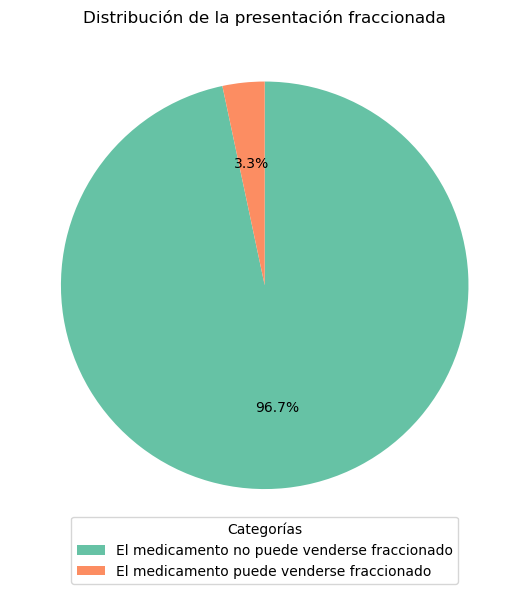

In [133]:
col = "apresentacaoFracionada"

counts = df[col].value_counts(dropna=False)

map_labels = {
    True: "El medicamento puede venderse fraccionado",
    False: "El medicamento no puede venderse fraccionado",
    np.nan: "No informado"
}
labels = counts.index.map(map_labels)

colors = sns.color_palette("Set2", n_colors=len(counts))

plt.figure(figsize=(12,6))
wedges, texts, autotexts = plt.pie(
    counts,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    counterclock=False
)

plt.legend(
    wedges,
    labels,
    title="Categorías",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=1
)

plt.title("Distribución de la presentación fraccionada")
plt.tight_layout()
plt.show()


In [134]:
df.restricaoHospitais

0         SI
1         SI
2         SI
3         No
4         No
          ..
206988    No
206989    No
206990    No
206991    No
206992    No
Name: restricaoHospitais, Length: 206993, dtype: category
Categories (3, object): ['SI' < 'No' < 'No informa']

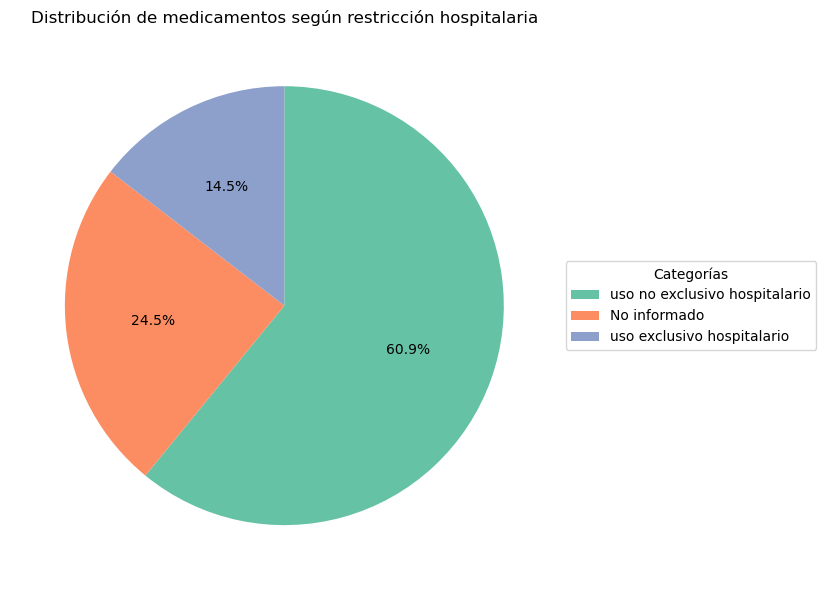

In [135]:
col = "restricaoHospitais"

counts = df[col].value_counts(dropna=False)

map_labels = {
    "SI": "uso exclusivo hospitalario",
    "No": "uso no exclusivo hospitalario",
    "No informa": "No informado"
}
labels = counts.index.map(map_labels)

colors = sns.color_palette("Set2", n_colors=len(counts))

plt.figure(figsize=(12,6))
wedges, texts, autotexts = plt.pie(
    counts,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    counterclock=False
)

plt.legend(
    wedges,
    labels,
    title="Categorías",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncol=1
)

plt.title("Distribución de medicamentos según restricción hospitalaria")
plt.tight_layout()
plt.show()


                                       conteo  porcentaje
destinacao_es                                            
uso comercial                          148509       71.75
uso hospitalario                        34015       16.43
uso institucional                       17708        8.55
No informado                             4273        2.06
uso profesional/empresa especializada    1359        0.66
uso en embalaje múltiple                 1129        0.55


/tmp/ipykernel_99454/2703744869.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([""])


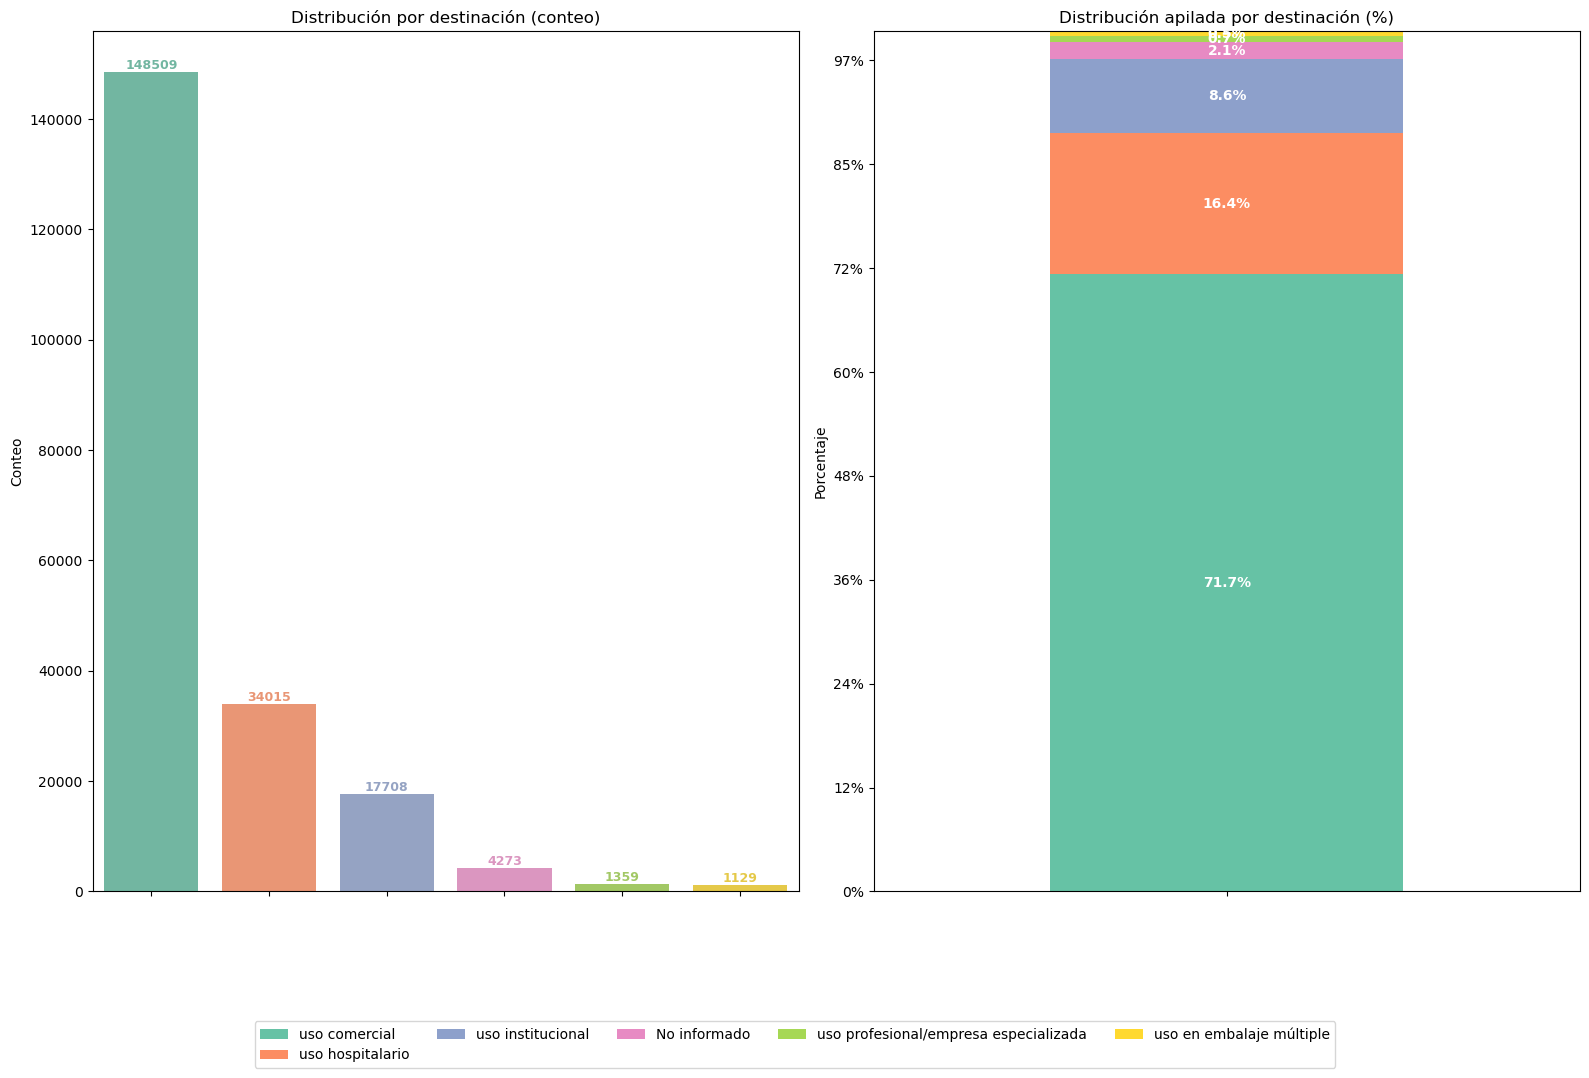

In [136]:
# --- 1) Traducción categorías ---
traducciones_dest = {
    "Comercial": "uso comercial",
    "Embalagem múltipla ": "uso en embalaje múltiple",   # ojo con el espacio final
    "Hospitalar": "uso hospitalario",
    "Institucional": "uso institucional",
    "Profissional /Empresa Especializada": "uso profesional/empresa especializada",
    np.nan: "No informado"
}

df["destinacao_es"] = df["destinacao"].map(traducciones_dest).fillna("No informado")

# --- 2) Resumen (conteo y %) ---
desc = df["destinacao_es"].value_counts(dropna=False).to_frame(name="conteo")
desc["porcentaje"] = round(100 * desc["conteo"] / len(df), 2)
print(desc)

# 3) Preparar orden (mayor a menor) y conteos
orden = df["destinacao_es"].value_counts().index
counts = df["destinacao_es"].value_counts()
total = counts.sum()
porcentajes = counts / total * 100
data = counts.to_frame().T  # una fila para stacked

# 4) Paleta de colores consistente por categoría
colores_base = sns.color_palette('Set2', n_colors=len(orden))
colores = {cat: colores_base[i] for i, cat in enumerate(orden)}

# 5) Figura con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# --- (A) Conteo por categoría ---
sns.countplot(
    data=df,
    x="destinacao_es",
    order=orden,
    hue="destinacao_es",
    palette=colores,
    legend=False,
    ax=axes[0]
)

# Etiquetas de valor encima de cada barra
for p in axes[0].patches:
    height = p.get_height()
    if height > 0:
        axes[0].text(
            p.get_x() + p.get_width() / 2,
            height + 0.5,
            int(height),
            ha="center", va="bottom", fontsize=9, fontweight="bold",
            color=p.get_facecolor()
        )

axes[0].set_title("Distribución por destinación (conteo)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Conteo")
axes[0].set_xticklabels([""])

# --- (B) Barra apilada con % ---
ax = data[orden].plot(
    kind='bar',
    stacked=True,
    color=[colores[c] for c in orden],
    legend=False,
    ax=axes[1]
)

# Eje Y en % (0–100) usando el total como denominador
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=total))
axes[1].set_ylim(0, total)
axes[1].set_title("Distribución apilada por destinación (%)")
axes[1].set_xlabel("")
axes[1].set_ylabel("Porcentaje")
axes[1].set_xticklabels([""]) 
# Añadir % dentro de cada segmento
acum = 0
for cat, val in counts[orden].items():
    y = acum + val/2
    axes[1].text(
        0, y, f"{(val/total*100):.1f}%",
        ha="center", va="center", color="white",
        fontsize=10, fontweight="bold"
    )
    acum += val

# 6) Leyenda única compartida
handles = [Patch(facecolor=colores[c], label=c) for c in orden]
fig.legend(handles=handles, loc="lower center",
           ncol=min(len(orden), 5), bbox_to_anchor=(0.5, -0.08))

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

In [137]:
# Diccionario de estados de Brasil
map_estados = {
    'SP': 'São Paulo',
    'PR': 'Paraná',
    'MG': 'Minas Gerais',
    'CE': 'Ceará',
    'GO': 'Goiás',
    'DF': 'Distrito Federal',
    'PE': 'Pernambuco',
    'AM': 'Amazonas',
    'RJ': 'Rio de Janeiro',
    'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul',
    'SC': 'Santa Catarina',
    'BA': 'Bahia',
    'ES': 'Espírito Santo',
    'PI': 'Piauí',
    np.nan: "No informado"
}

df["fabricantesNacionais_estado"] = df["fabricantesNacionais_uf"].map(map_estados).fillna("No informado")


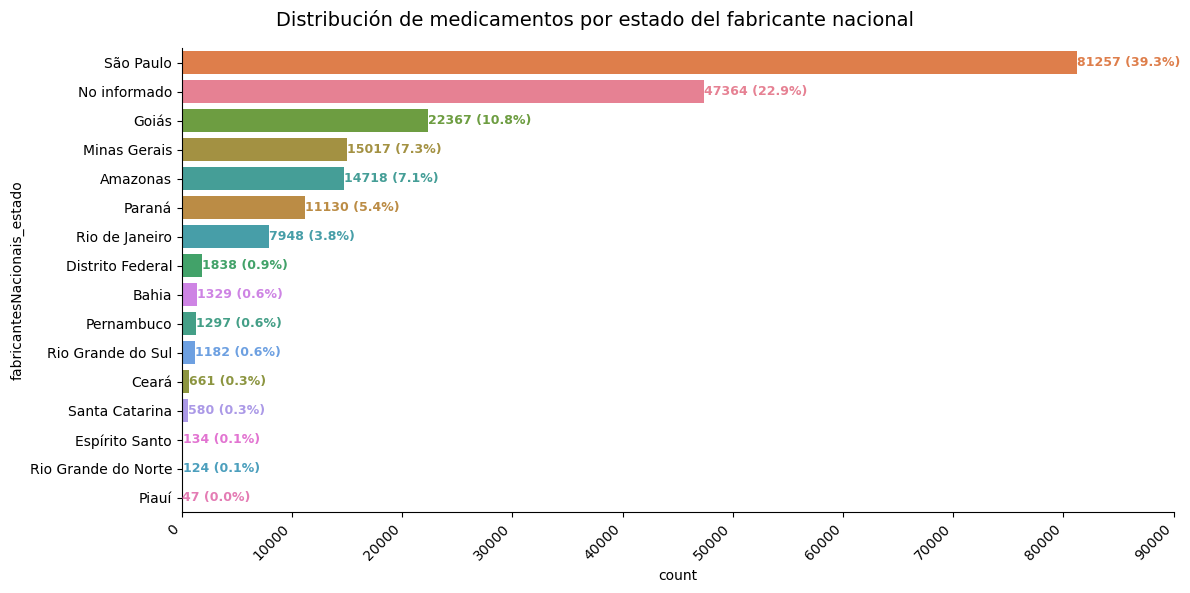

In [138]:
g = sns.catplot(
    data=df,
    y="fabricantesNacionais_estado",
    kind="count",
    order=df["fabricantesNacionais_estado"].value_counts().index,
    height=6,
    aspect=2,
    hue="fabricantesNacionais_estado",
    legend=False
)

# Centrar etiquetas bajo cada barra
g.set_xticklabels(rotation=45, ha="right")

# Agregar valores encima de cada barra
ax = g.ax
for p in ax.patches:
    width = p.get_width()  # conteo
    if width > 0:
        porcentaje = width / total * 100
        ax.text(
            width + 0.5,                      
            p.get_y() + p.get_height() / 2,   
            f"{int(width)} ({porcentaje:.1f}%)", 
            ha="left", va="center",
            fontsize=9, fontweight="bold",
            color=p.get_facecolor()
        )


# Título
g.figure.suptitle("Distribución de medicamentos por estado del fabricante nacional", fontsize=14)

plt.tight_layout()
plt.show()



In [139]:
df.dtypes

nomeProduto                                  string[python]
numeroProcesso                               string[python]
empresaNome                                  string[python]
principioAtivo                               string[python]
tarja                                              category
medicamentoReferencia                        string[python]
classesTerapeuticas                          string[python]
categoriaRegulatoria                               category
dataProduto                                  datetime64[ns]
dataVencimentoRegistro                       datetime64[ns]
dataPublicacao                               datetime64[ns]
apresentacoes.codigo                         string[python]
apresentacao                                 string[python]
apresentacoes.dataPublicacao                 datetime64[ns]
registro                                     string[python]
principiosAtivos                             string[python]
embalagemSecundariaTodas                

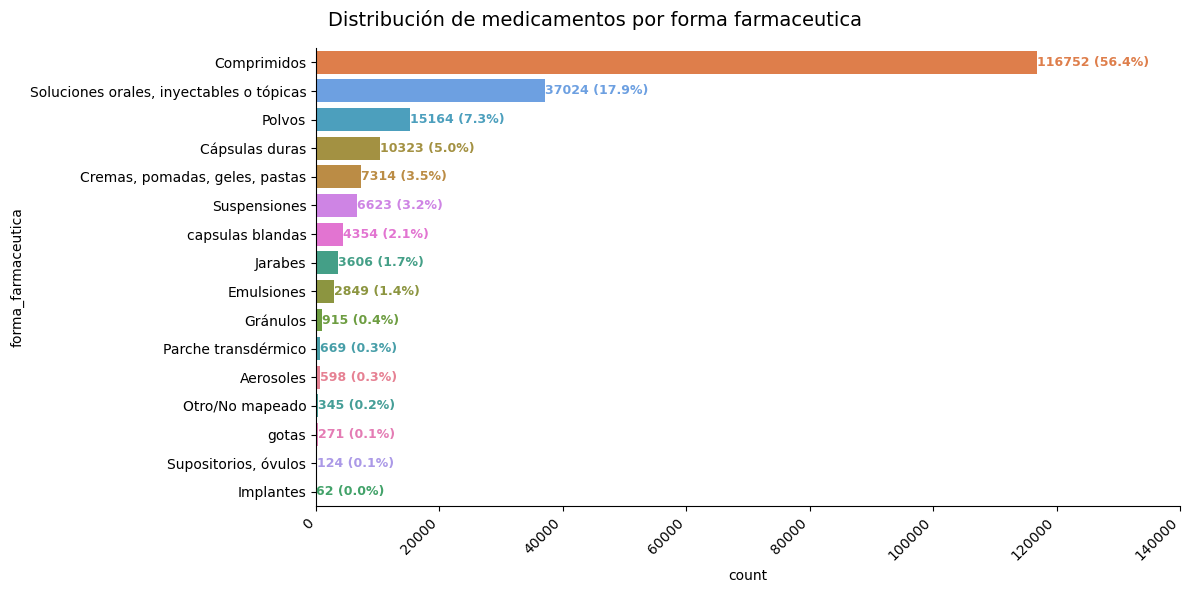

In [140]:
g = sns.catplot(
    data=df,
    y="forma_farmaceutica",
    kind="count",
    order=df["forma_farmaceutica"].value_counts().index,
    height=6,
    aspect=2,
    hue="forma_farmaceutica",
    legend=False
)

# Centrar etiquetas bajo cada barra
g.set_xticklabels(rotation=45, ha="right")

# Agregar valores encima de cada barra
ax = g.ax
for p in ax.patches:
    width = p.get_width()  # conteo
    if width > 0:
        porcentaje = width / total * 100
        ax.text(
            width + 0.5,                      
            p.get_y() + p.get_height() / 2,   
            f"{int(width)} ({porcentaje:.1f}%)", 
            ha="left", va="center",
            fontsize=9, fontweight="bold",
            color=p.get_facecolor()
        )


# Título
g.figure.suptitle("Distribución de medicamentos por forma farmaceutica", fontsize=14)

plt.tight_layout()
plt.show()


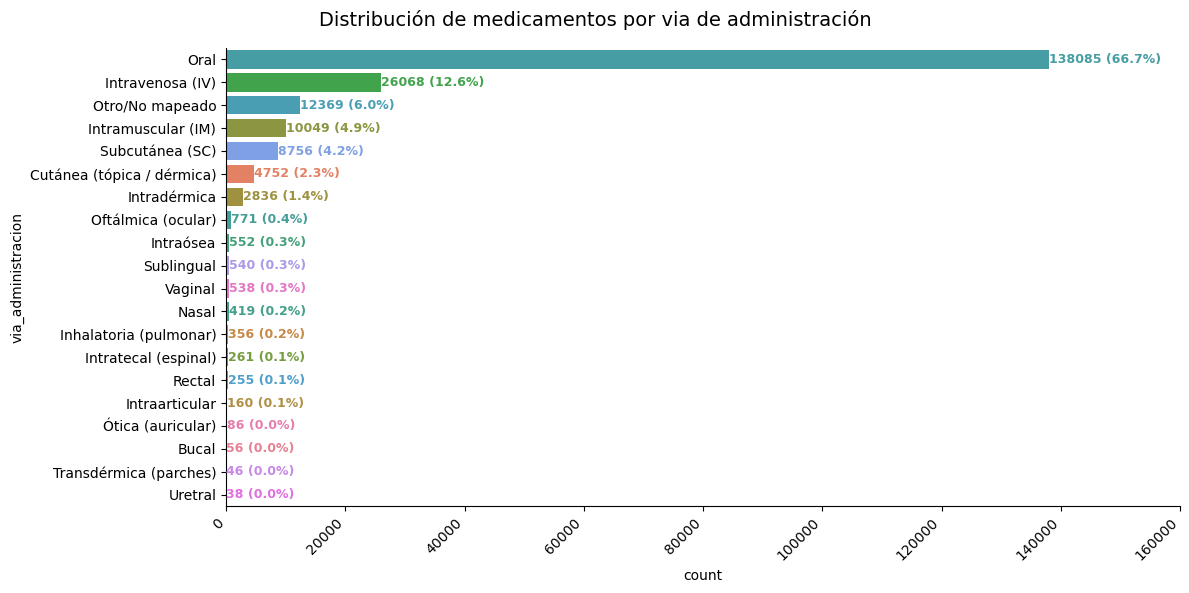

In [143]:
g = sns.catplot(
    data=df,
    y="via_administracion",
    kind="count",
    order=df["via_administracion"].value_counts().index,
    height=6,
    aspect=2,
    hue="via_administracion",
    legend=False
)

# Centrar etiquetas bajo cada barra
g.set_xticklabels(rotation=45, ha="right")

# Agregar valores encima de cada barra
ax = g.ax
for p in ax.patches:
    width = p.get_width()  # conteo
    if width > 0:
        porcentaje = width / total * 100
        ax.text(
            width + 0.5,                      
            p.get_y() + p.get_height() / 2,   
            f"{int(width)} ({porcentaje:.1f}%)", 
            ha="left", va="center",
            fontsize=9, fontweight="bold",
            color=p.get_facecolor()
        )


# Título
g.figure.suptitle("Distribución de medicamentos por via de administración", fontsize=14)

plt.tight_layout()
plt.show()

In [167]:
df.to_parquet("df_final_univariado.parquet", engine="pyarrow", index=False)